In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from transformers import GPT2Tokenizer
from src.model import GPT

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

/home/jiajun/Sharing/uncover-hidden-geometry/.uncover/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model = GPT.from_pretrained("gpt2").to("cuda")

In [94]:
def create_random_repeated_seq(length=10, repeat=3):
    single = np.random.randint(0, 50000, length)
    seq = np.concatenate([single for _ in range(repeat)])
    seq = torch.tensor(seq).unsqueeze(0).to("cuda")
    return seq


def unembd(vector, topk=5):
    final_ln_layer = model.lm_head
    if not isinstance(vector, torch.Tensor):
        vector = torch.tensor(vector).to("cuda")
    scores = final_ln_layer(vector).numpy(force=True)

    if topk == "max":
        return np.argsort(scores)[::-1]
    return np.argsort(scores)[::-1][:topk]


def untoken(tokens):
    if isinstance(tokens, torch.Tensor) and len(tokens.size()) > 1:
        tokens = tokens[0]
    return [tokenizer.decode(t) for t in tokens]


def largest_indices(v, topk=5):
    return np.argsort(v)[::-1][:topk]


def get_multiple_hiddens(seq):
    h = []
    with torch.no_grad():
        t = model.transformer.wte(seq)
        pos = torch.arange(0, seq.size(1), dtype=torch.long, device="cuda").unsqueeze(0)
        p = model.transformer.wpe(pos)
        x = model.transformer.drop(t + p)

        for i, block in enumerate(model.transformer.h):
            # x = x + self.attn(self.ln_1(x))
            # x = x + self.mlp(self.ln_2(x))

            x0 = block.ln_1(x)
            x1 = block.attn(x0)
            x2 = x + x1
            x3 = block.ln_2(x2)
            x4 = block.mlp(x3)
            x5 = x2 + x4

            h += [np.vstack([xx.numpy(force=True) for xx in [x0, x1, x2, x3, x4, x5]])]

            x = x5

    return np.array(h)


def find_pos(tokens, t):
    if isinstance(tokens, torch.Tensor):
        tokens = tokens[0].numpy(force=True)
    if t in list(tokens):
        return list(tokens).index(t)
    return -1


def get_hiddens_alphas_vectors(seq):
    alphas = []
    vectors = []
    hiddens = []
    with torch.no_grad():
        t = model.transformer.wte(seq)
        pos = torch.arange(0, seq.size(1), dtype=torch.long, device="cuda").unsqueeze(0)
        p = model.transformer.wpe(pos)
        x = model.transformer.drop(t + p)

        for i, block in enumerate(model.transformer.h):
            x = x + block.attn(block.ln_1(x))
            tmp = block.ln_2(x)
            mlp = block.mlp
            alpha = mlp.gelu(mlp.c_fc(tmp))
            r = mlp.c_proj(alpha)
            r = mlp.dropout(r)

            alphas.append(alpha.numpy(force=True)[0])

            x += r

            v = mlp.c_proj.weight.T
            if i < 11:
                h = model.transformer.h[i + 1].ln_1(x)
                v = model.transformer.h[i + 1].ln_1(v)
            else:
                h = model.transformer.ln_f(x)
                v = model.transformer.ln_f(v)

            hiddens.append(h.numpy(force=True)[0])
            vectors.append(v.numpy(force=True))

    return np.array(hiddens), np.array(alphas), np.array(vectors)

In [79]:
def calculate_pos(tokens):
    indices = []
    hiddens = get_multiple_hiddens(tokens)
    for layer in range(5, 12):
        for i, x in enumerate(hiddens[layer, :, -1]):
            t = unembd(x, topk=100)
            to_find = tokens[0, 0]
            p = find_pos(t, to_find)
            if p < 0:
                p = 100
            indices.append(p)
    return indices


pall = []
for _ in range(100):
    tokens = create_random_repeated_seq()
    pos = calculate_pos(tokens)
    pall.append(pos)

In [95]:
tokens = create_random_repeated_seq()
print(untoken(tokens)[:10])

hiddens = get_multiple_hiddens(tokens)
for layer in range(5, 12):
    print("Layer", layer)
    for i, x in enumerate(hiddens[layer, :, -1]):
        print(f"Hidden {i}", untoken(unembd(x, topk=10)))
        t = unembd(x, topk=1000)

[' deprecated', ' reactions', ' grams', ' vote', ' incess', ' lobbyists', ' disarm', 'cemic', ' Brewers', ' foster']
Layer 5
Hidden 0 [' the', ' a', '-', ',', ' and', ' in', '.', ' an', ' to', ' (']
Hidden 1 [',', '.', ' (', ' and', ' to', ' for', '-', '\n', ' –', ':']
Hidden 2 [' the', '-', ' a', ',', ' and', '.', ' to', ' (', ' in', ' for']
Hidden 3 ['-', ' -', ' (', ' and', ' 9', ' 2', ' a', ' to', '.', ' the']
Hidden 4 ['quickShipAvailable', 'OTOS', ' guiActiveUn', 'gotten', 'cloth', 'BuyableInstoreAndOnline', ' CLSID', 'ドラ', 'Tonight', ' guiActiveUnfocused']
Hidden 5 [' the', '-', ' a', ',', '.', ' and', ' (', ' to', ' in', ' an']
Layer 6
Hidden 0 ['-', ' a', ' the', '.', ' (', ' and', ',', ' to', ' an', ' for']
Hidden 1 [' undefined', ' de', ' supra', 'ou', ' violation', ' und', '_', ' and', ' disl', ' dis']
Hidden 2 [' the', '-', ' a', ',', ' and', ' (', '.', '\n', ' in', ' an']
Hidden 3 ['-', ' (', ' and', ' -', '.', ',', '/', '\n', ' 2', ' a']
Hidden 4 [' Gothic', ' Together',

In [ ]:
tokens = create_random_repeated_seq()
print(untoken(tokens)[:10])

hiddens, alphas, vectors = get_hiddens_alphas_vectors(tokens)
for layer in range(6, 12):
    print("Layer", layer)
    h = hiddens[layer, -1]
    a = alphas[layer, -1]
    v = vectors[layer]
    aL = largest_indices(a)

    print("Hidden", untoken(unembd(h, topk=10)))
    print("Weight")
    for i in aL:
        print(i, untoken(unembd(v[i], topk=3)))
    print("\n")

In [ ]:
num_top = 20
layer = 10
mlp = model.transformer.h[layer].mlp
final_lin_layer = model.lm_head

idx = 40

v = mlp.c_proj.weight[:, idx]
scores = final_lin_layer(v).numpy(force=True)

tmp = np.argsort(scores)[::-1]
tokenizer.convert_ids_to_tokens(tmp[:num_top])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch

pos = np.load("out/gpt2-openwebtext/pos_id1-512_none_train.npy")
cvec = np.load("out/gpt2-openwebtext/cbasis_id1-512_none_train.npy")

In [4]:
def show(p, title):
    fig, ax = plt.subplots(3, 4, sharex=True, sharey=True)
    for i in range(11):
        pp = p[i]
        u, s, vt = np.linalg.svd(pp)
        pc2 = pp @ vt[:2, :].T
        ax[i // 4][i % 4].plot(pc2[:, 0], pc2[:, 1])
    plt.suptitle(title)
    plt.show()

def show_one(p, title):
    T = p.shape[0]
    u, s, vt = np.linalg.svd(p)
    pc2 = p @ vt[:2, :].T
    colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, T)]
    plt.scatter(pc2[:, 0], pc2[:, 1], c=colors_blue)
    plt.title(title)

titles = """x0 = block.ln_1(x)
x1 = block.attn(x0)
x2 = x + x1
x3 = block.ln_2(x2)
x4 = block.mlp(x3)
x5 = x2 + x4""".splitlines()

for layer in range(12):
    for type in range(6):
        p = pos[layer, type]
        show_one(p, titles[type])
        plt.savefig(f"Figures/gpt-openwebtext/{layer}-{type}.png")
        plt.close()

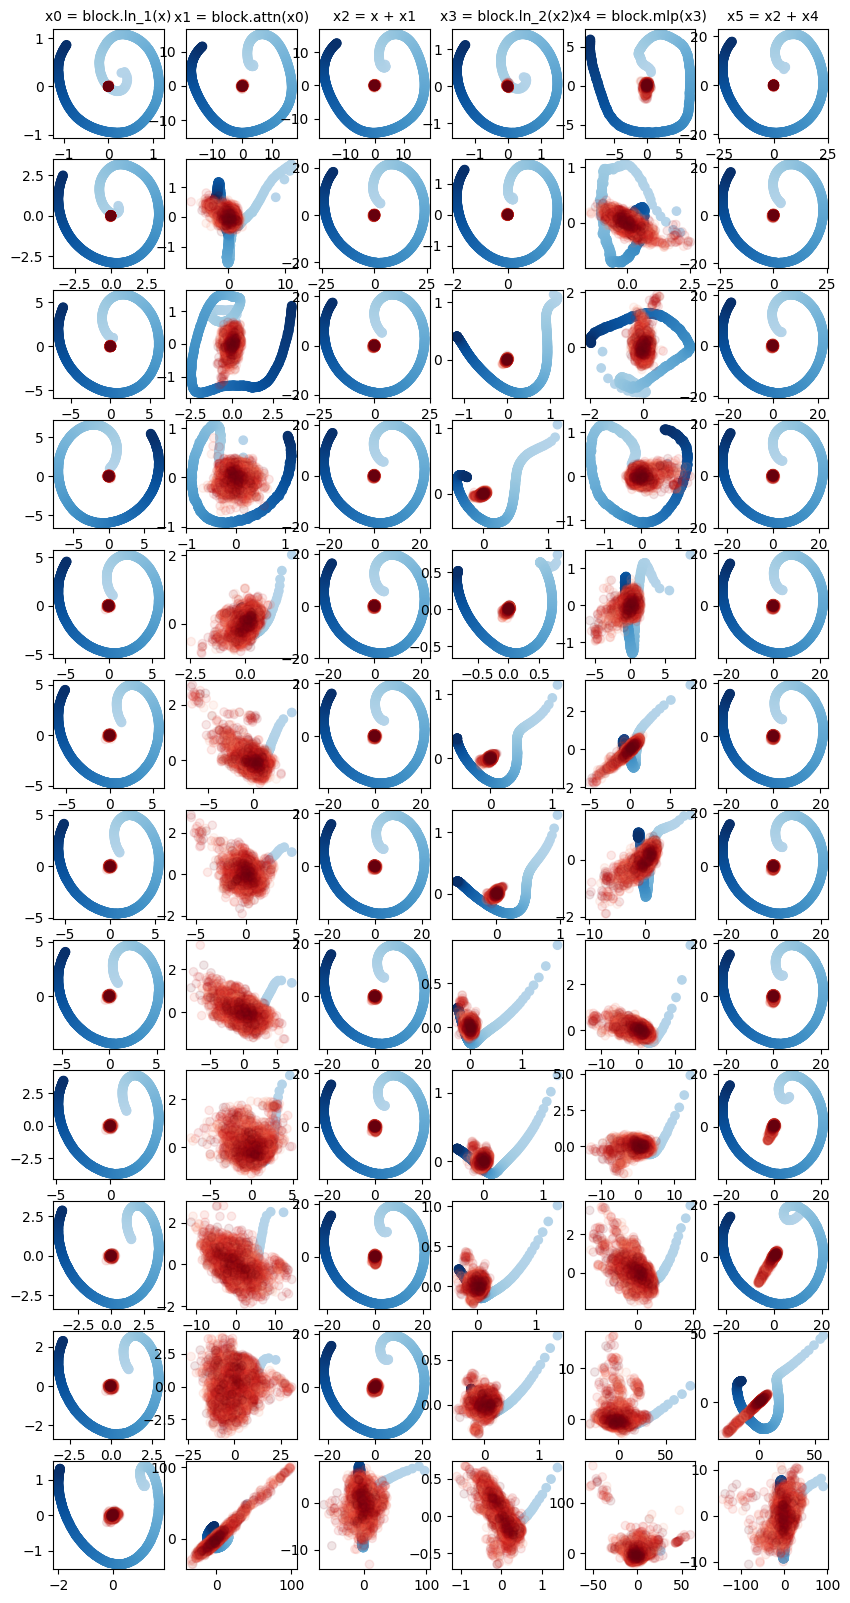

In [25]:
fig, ax = plt.subplots(12, 6, figsize=(10, 20))
for layer in range(12):
    for type in range(6):
        p = pos[layer, type]
        T = p.shape[0]
        u, s, vt = np.linalg.svd(p)
        pc2 = p @ vt[:2, :].T
        colors_blue = [plt.cm.Blues(x) for x in np.linspace(0.3, 1, T)]
        ax[layer][type].scatter(pc2[:, 0], pc2[:, 1], c=colors_blue)

        c = cvec[layer, type, : 10 * T]
        pc2 = c @ vt[:2, :].T
        colors_red = np.array(
            [plt.cm.Reds(x) for x in np.linspace(0.3, 1, T)] * 10
        )
        ax[layer][type].scatter(pc2[:, 0], pc2[:, 1], c=colors_red, alpha=0.1)

        if layer == 0:
            ax[layer][type].set_title(titles[type], fontsize=10)

plt.savefig("Figures/gpt-openwebtext/all_cvec.png")

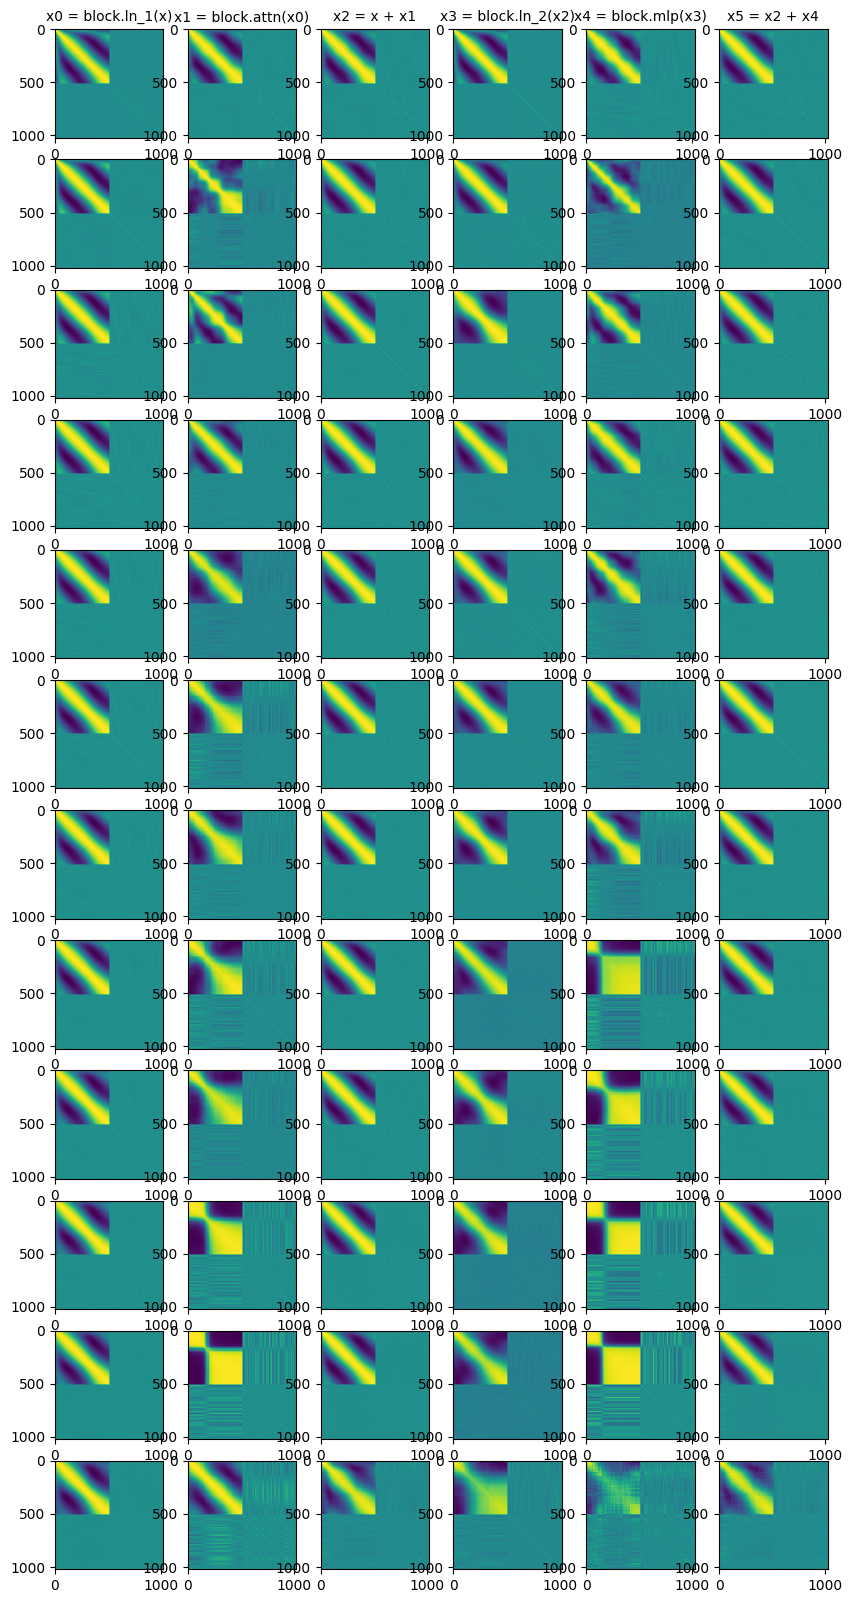

In [6]:
fig, ax = plt.subplots(12, 6, figsize=(10, 20))
for layer in range(12):
    for type in range(6):
        p = pos[layer, type]
        T = p.shape[0]
        c = cvec[layer, type, : T]
        combined = np.vstack([p, c])
        combined = combined / np.sqrt(np.sum(combined**2, axis=1, keepdims=True))
        g = combined @ combined.T
        ax[layer][type].imshow(g)

        if layer == 0:
            ax[layer][type].set_title(titles[type], fontsize=10)

plt.savefig("Figures/gpt-openwebtext/gram.png")